In [1]:
import torch

# Confirm that the GPU is detected

assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla T4, n_gpu: 1


In [2]:
!pip install transformers
!pip install -U -q PyDrive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install git+https://github.com/adapter-hub/adapter-transformers.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/adapter-hub/adapter-transformers.git to /tmp/pip-req-build-8mr_qnip
  Running command git clone --filter=blob:none --quiet https://github.com/adapter-hub/adapter-transformers.git /tmp/pip-req-build-8mr_qnip
  Resolved https://github.com/adapter-hub/adapter-transformers.git to commit b7c9c38888f7707d206860eb1c0f7366a1776ed0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import pandas as pd
from transformers import XLMRobertaForSequenceClassification, AdamW, XLMRobertaConfig
from torch.utils.data import TensorDataset, random_split
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import sys
import numpy as np
import time
import datetime

def tokenize_and_format(sentences):
  tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base", do_lower_case=False)

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sentence in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sentence,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 64,           # Pad & truncate all sentences.
                          padding = 'max_length',
                          truncation = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      # Add the encoded sentence to the list.
      input_ids.append(encoded_dict['input_ids'])

      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])
  return input_ids, attention_masks

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


The cell below imports some helper functions we wrote to demonstrate the task on the sample tweet dataset.

In [5]:
import pandas as pd

data = pd.read_csv("/content/NLP Ethos - ethos.csv")
data = data.sample(frac = 1).reset_index(drop=True)
total = data.shape[0]
train_data = data.iloc[:801, 2:]
validation_data_eng = data.iloc[801:944, 2:]
validation_data_hindi = data.iloc[944:, 2:]
train_data.head()

,Label,Translation
0,0,मुझे समझ नहीं आता कि हम बस एक ट्रांसजेंडर श्रे...
1,1,"यह बीमार, घिनौना, सफेद आतंकवादी/फासीवादी 50 से..."
2,1,"Come out of the closet, we know you're in ther..."
3,1,Dumb ass liberals look at these refugees like ...
4,1,Filthy Chinese


In [6]:
validation_data_eng.head()

,Label,Translation
801,1,महिला को इसलिए यह सब सहना पड़ा था क्योंकि वह ब...
802,1,Fat white cuntï»¿
803,0,No shower for two days? I bet you smell like D...
804,0,Pokemon is the best game ever
805,1,निष्पादित OHOMO और उसके किन्नर कुतिया माइक।


In [7]:
validation_data_hindi.head()

,Label,Translation
944,0,"हॉलीवुड सबसे विचित्र, सबसे अस्वस्थ और सबसे बुर..."
945,1,Get OUT of the EU. Italy vote to get the fuck ...
946,0,"Omg, Macklemore is iconic and I love him."
947,1,When I see men running with those plastic legs...
948,1,पीरियड को एक प्राकृतिक प्रक्रिया के रूप में बत...


In [8]:
print('Shape of training data is:', train_data.shape)
print('Shape of validation data (eng) is:', validation_data_eng.shape)
print('Shape of validation data (hindi) is:', validation_data_hindi.shape)

train_len = train_data.shape[0]
val_len_eng = validation_data_eng.shape[0]
val_len_hindi = validation_data_hindi.shape[0]

Shape of training data is: (801, 2)
Shape of validation data (eng) is: (143, 2)
Shape of validation data (hindi) is: (78, 2)


<Axes: xlabel='Label', ylabel='count'>

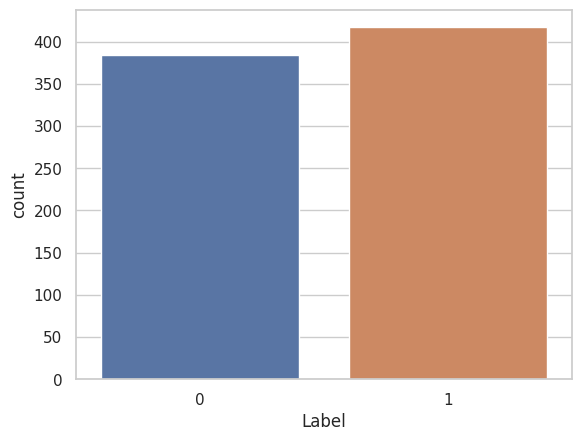

In [9]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.countplot(x=train_data['Label'])

<Axes: xlabel='Label', ylabel='count'>

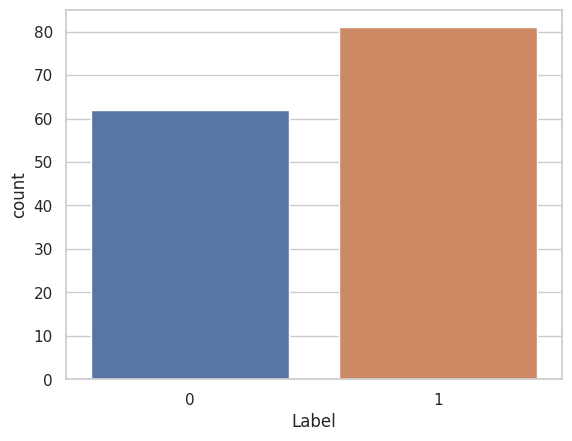

In [10]:
sns.set_theme(style="whitegrid")
sns.countplot(x=validation_data_eng['Label'])

<Axes: xlabel='Label', ylabel='count'>

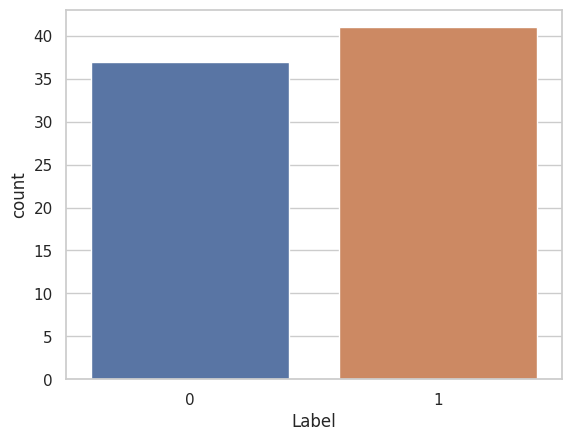

In [11]:
sns.set_theme(style="whitegrid")
sns.countplot(x=validation_data_hindi['Label'])

In [12]:
text = data.Translation.values
labels = data.Label.values

### tokenize_and_format() is a helper function provided in helpers.py ###
input_ids, attention_masks = tokenize_and_format(text)

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', text[0])
print('Token IDs:', input_ids[0])

Original:  मुझे समझ नहीं आता कि हम बस एक ट्रांसजेंडर श्रेणी क्यों नहीं बना देते। सबसे साफ़ और निष्पक्ष समाधान लगता है। महान एथलीट अभी भी प्रतिस्पर्धा करेंगे। और खेल मैदान सबसे निष्पक्ष होगा। मुझे मतलब है, हम बॉक्सिंग / एमएमए लड़ाइयों की निष्पक्षता को अधिकतम करने के लिए वजन श्रेणियां बनाते हैं। हम जानते हैं कि केवल दो व्यक्ति जिसमें दोनों पुरुष होते हैं वे अलग-अलग स्तरों पर प्रतिस्पर्धा करते हैं। ट्रांसजेंडर एथलीटों के लिए भी हम ऐसा कर सकते हैं, क्या?
Token IDs: tensor([     0,  22839,  41126,   2191,  14372,   1682,  10215,   9188,    967,
        235927,  21294,  99046, 145247,  35024,   2191,  17837,  61236,    125,
         13353,   5268,  36887,    871,  95268,  88930,  57854,  70915,    460,
           125,  99832,   9489,   8531,   2416,   2653,  38159,   1780, 152578,
         58898,    125,    871,  12189,  78177,  13353,  95268,  88930,  16492,
           125,  22839, 144692,    460,      4,  10215, 173471,  10067,    248,
         39477, 225067,  79563, 190885,    838,    471

In [13]:
train_data = data.iloc[:801, 2:]
validation_data_eng = data.iloc[801:944, 2:]
validation_data_hindi = data.iloc[944:, 2:]

# make lists of 3-tuples (already shuffled the dataframe in cell above)

train_set = [(input_ids[i], attention_masks[i], labels[i]) for i in range(801)]
val_set_eng = [(input_ids[i], attention_masks[i], labels[i]) for i in range(801, 944)]
val_set_hindi = [(input_ids[i], attention_masks[i], labels[i]) for i in range(944, total)]


train_text = [text[i] for i in range(801)]
val_text_eng = [text[i] for i in range(801, 944)]
val_text_hindi = [text[i] for i in range(944, total)]

In [14]:
data_eng = pd.read_csv("/content/final dataset - eng - Sheet1.csv")

test_data_eng = data_eng.iloc[:, 1:]
test_data_eng.head()

,label,Translations
0,1,Men do things for women without expecting sex.
1,1,"It's on, bitch!"
2,1,That stupid self-centered bastard wrote about ...
3,1,While I have no respect for Leslie as a scient...
4,1,"Well, what are you going to do about it, bitch?"


In [15]:
data_hindi = pd.read_csv("/content/final_dataset - hindi - Sheet1.csv")

test_data_hindi = data_hindi.iloc[:, 1:]
test_data_hindi.head()

,label,Translations
0,0,मुझसे नहीं हो रहा। मैं महिलाओं से निपटने से तं...
1,0,क्योंकि तुम एक मर्द हो। जेंडर का शैम्पेन।
2,0,"अच्छा, मैं मर्द हूं, लेकिन मुझसे गलती हुई है, ..."
3,0,"हाँ, ठीक है, तुम मर्द की तरह स्वीकार करते हो।"
4,0,वह आरंभ हार्प बजाती है और उसकी कार का भुगतान ह...


In [16]:
test_text_eng = test_data_eng.Translations.values
test_labels_eng = test_data_eng.label.values
test_len_eng = test_data_eng.shape[0]

### tokenize_and_format() is a helper function provided in helpers.py ###
test_input_ids_eng, test_attention_masks_eng = tokenize_and_format(test_text_eng)

# Convert the lists into tensors.
test_input_ids_eng = torch.cat(test_input_ids_eng, dim=0)
test_attention_masks_eng = torch.cat(test_attention_masks_eng, dim=0)
test_labels_eng = torch.tensor(test_labels_eng)

# Print sentence 0, now as a list of IDs.
print('Original: ', test_text_eng[0])
print('Token IDs:', test_input_ids_eng[0])

test_set_eng = [(test_input_ids_eng[i], test_attention_masks_eng[i], test_labels_eng[i]) for i in range(test_len_eng)]

Original:  Men do things for women without expecting sex.
Token IDs: tensor([    0,  1111,    54,  8966,   100, 24793, 15490, 41206,   214,  1100,
            5,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1])


In [17]:
test_text_hindi = test_data_hindi.Translations.values
test_labels_hindi = test_data_hindi.label.values
test_len_hindi = test_data_hindi.shape[0]

### tokenize_and_format() is a helper function provided in helpers.py ###
test_input_ids_hindi, test_attention_masks_hindi = tokenize_and_format(test_text_hindi)

# Convert the lists into tensors.
test_input_ids_hindi = torch.cat(test_input_ids_hindi, dim=0)
test_attention_masks_hindi = torch.cat(test_attention_masks_hindi, dim=0)
test_labels_hindi = torch.tensor(test_labels_hindi)

# Print sentence 0, now as a list of IDs.
print('Original: ', test_text_hindi[0])
print('Token IDs:', test_input_ids_hindi[0])

test_set_hindi = [(test_input_ids_hindi[i], test_attention_masks_hindi[i], test_labels_hindi[i]) for i in range(test_len_hindi)]

Original:  मुझसे नहीं हो रहा। मैं महिलाओं से निपटने से तंग आ गया हूँ।
Token IDs: tensor([     0, 218373,   2191,   1253,   7172,    125,  10399,  73457,    646,
          5366,  68319,   1187,    646,   3418,  10378,   2220,   5349,  28035,
           125,      2,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1])


In [18]:
from transformers import XLMRobertaForSequenceClassification, AdamW, XLMRobertaConfig

model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", # Use the base XLM-Roberta model
    num_labels = 2, # The number of output labels
    output_attentions = False, # Whether the model returns attention weights
    output_hidden_states = False, # Whether the model returns all hidden states
)

'''from transformers.adapters import PfeifferInvConfig

config = PfeifferInvConfig()
model.add_adapter("lang_adapter", config=config)
model.set_active_adapters("lang_adapter")'''

from transformers.adapters import LoRAConfig

'''config = LoRAConfig(r=8, alpha=16)
model.add_adapter("lora_adapter", config=config)
model.set_active_adapters("lora_adapter")'''

# Tell PyTorch to run this model on the GPU
model.cuda()


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

XLMRobertaForSequenceClassification(
  (shared_parameters): ModuleDict()
  (roberta): XLMRobertaModel(
    (shared_parameters): ModuleDict()
    (invertible_adapters): ModuleDict()
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(
                in_features=768, out_features=768, bias=True
                (loras): ModuleDict()
              )
              (key): Linear(
                in_features=768, out_features=768, bias=True
                (loras): ModuleDict()
              )

In [19]:
batch_size = 50
optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # args.learning_rate - default is 5e-5
                  eps = 15e-8 # args.adam_epsilon  - default is 1e-8
                )
epochs = 10

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
import numpy as np
# function to get validation accuracy
def get_validation_performance(val_set, val_len):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    batch_size = 20

    num_batches = int(val_len/batch_size) + 1

    total_correct = 0
    mismatch_ids = []

    for i in range(num_batches):
      #print(i)
      end_index = min(batch_size * (i+1), len(val_set))
      #print(end_index)
      #print(i*batch_size)

      batch = val_set[i*batch_size:end_index]
      
      if len(batch) == 0: continue

      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()

        
        batch_mismatch_ids = [index for index, elem in enumerate(labels_flat) if elem!=pred_flat[index]]
        batch_mismatch_ids = [index + i*batch_size for index in batch_mismatch_ids]
        print(batch_mismatch_ids)
        mismatch_ids += batch_mismatch_ids

        num_correct = np.sum(pred_flat == labels_flat)
        total_correct += num_correct
        
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_correct / len(val_set)
    return mismatch_ids, avg_val_accuracy

In [21]:
import random
# Set max_split_size_mb to 200 MB
#torch.cuda.set_per_process_memory_fraction(1, device=None)

# training loop

# For each epoch...
for epoch_i in range(0, epochs):
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()
    #print(train_len)
    # For each batch of training data...
    num_batches = int(train_len/batch_size) + 1
    #print(batch_size)
    #print(num_batches)

    for i in range(num_batches):
      #print(i)
      end_index = min(batch_size * (i+1), len(train_set))

      batch = train_set[i*batch_size:end_index]
      #print(len(batch))

      if len(batch) == 0: continue

      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])

      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)

      #print(b_input_ids.shape)

      # Clear the previously calculated gradient
      model.zero_grad()        

      # Perform a forward pass (evaluate the model on this training batch).
      # Perform a forward pass (evaluate the model on this training batch).
      outputs = model(b_input_ids, 
                      token_type_ids=None,
                      attention_mask=b_input_mask, 
                      labels=b_labels)
      loss = outputs.loss
      logits = outputs.logits

      total_train_loss += loss.item()

      # Perform a backward pass to calculate the gradients.
      loss.backward()

      # Update parameters and take a step using the computed gradient.
      optimizer.step()
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set. Implement this function in the cell above.
    print(f"Total loss: {total_train_loss}")
    _, val_acc_eng = get_validation_performance(val_set_eng, val_len_eng)
    print(f"Validation accuracy English: {val_acc_eng}")
    _, val_acc_hindi = get_validation_performance(val_set_hindi, val_len_hindi)
    print(f"Validation accuracy Hindi: {val_acc_hindi}")
    
print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...
Total loss: 11.780312538146973
[2, 3, 6, 9, 11, 12, 16, 18]
[20, 23, 24, 25, 29, 30, 32, 38]
[40, 41, 42, 43, 45, 49, 50, 52, 54, 55, 58]
[67, 69, 70, 71, 75]
[81, 85, 87, 89, 94, 96]
[101, 103, 104, 105, 107, 108, 110, 112, 113, 116, 117]
[121, 123, 124, 125, 126, 127, 129, 131, 132, 133, 134, 135]
[]
Validation accuracy English: 0.5734265734265734
[0, 2, 6, 9, 10, 12, 13, 15, 16, 19]
[22, 24, 25, 26, 27, 28, 31, 32, 33, 34, 38, 39]
[40, 41, 45, 47, 49, 51, 55, 57, 59]
[60, 62, 63, 65, 66, 67]
Validation accuracy Hindi: 0.5256410256410257

======== Epoch 2 / 10 ========
Training...
Total loss: 11.61463713645935
[2, 3, 6, 9, 10, 11, 12, 16, 18]
[20, 23, 24, 25, 29, 30, 32, 38]
[43, 45, 49, 50, 52, 54, 58]
[60, 64, 67, 69, 70, 71, 72, 75]
[81, 82, 85, 87, 94, 96]
[101, 103, 105, 107, 110, 112, 113, 116, 117]
[124, 125, 129, 131, 132, 133, 134, 135]
[]
Validation accuracy English: 0.6153846153846154
[0, 9, 10, 12, 13, 16, 19]
[24, 25, 26, 27, 2

In [22]:
mismatch_ids_eng, test_acc_eng = get_validation_performance(test_set_eng, test_len_eng)
print(test_acc_eng)

[1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16]
[22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 34, 37, 38, 39]
[46, 52]
[]
0.5081967213114754


In [23]:
## YOUR ERROR ANALYSIS CODE HERE
## print out up to 5 test set examples (or adversarial examples) that your model gets wrong

incorrect_classif_instances_eng = []
for i in range(len(mismatch_ids_eng)):
  incorrect_classif_instances_eng.append(test_text_eng[i])

print(incorrect_classif_instances_eng)

['Men do things for women without expecting sex.', "It's on, bitch!", 'That stupid self-centered bastard wrote about our sex life on his blog.', 'While I have no respect for Leslie as a scientist or human being we must acknowledge her experience in the field of promiscuity and general slutiness', 'Well, what are you going to do about it, bitch?', 'Well, dead whore on TV, live one in real life', 'The lucky bastard. It\'s gotta be that stupid accent of his. "Hello, I\'m Sanjay Wolowitz from Bombay."', "Well, what are we waiting for? Let's bounce, bitches.", 'Then they named stupid Valerie Mosbacher head cheerleader. Big old slutbag.', 'Cause I’m the petty functionary with the clipboard, bitch', 'Now let’s talk about Priya, that man-stealing bitch', 'That crazy bastard’s looking at quirky in the rearview mirror', 'There are a lot of bitches out there', 'I feel like I’m supposed to say "that bitch", but I don\'t have enough information.', 'Oh that gossipy bitch! No offense, Raj', 'I can’t 

In [24]:
mismatch_ids_hindi, test_acc_hindi = get_validation_performance(test_set_hindi, test_len_hindi)
print(test_acc_hindi)

[5, 19]
[20, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 35, 36, 37, 38]
[40, 41, 42, 43, 45, 47, 51, 52, 53, 54]
0.5263157894736842


In [25]:
incorrect_classif_instances_hindi = []
for i in range(len(mismatch_ids_hindi)):
  incorrect_classif_instances_hindi.append(test_text_hindi[i])

print(incorrect_classif_instances_hindi)

['मुझसे नहीं हो रहा। मैं महिलाओं से निपटने से तंग आ गया हूँ।', 'क्योंकि तुम एक मर्द हो। जेंडर का शैम्पेन।', 'अच्छा, मैं मर्द हूं, लेकिन मुझसे गलती हुई है, यह मुझे लगता है।', ' हाँ, ठीक है, तुम मर्द की तरह स्वीकार करते हो।', 'वह आरंभ हार्प बजाती है और उसकी कार का भुगतान हो गया है। उससे ज्यादा खुश कैसे हो सकती है?', 'क्या आप दरवाजा खोलकर मेरे पीछे अंग्रेजी मारते हुए नहीं भागने देंगे?', 'मुझे लगता है आपको कुछ संपादन करना चाहिए, जैसे अपने बचपन के बारे में सब छोड़कर।', 'सभी व्यवसायिक और सामाजिक मीटिंग की शुरुआत और अंत में, सभी मौजूद लोगों से हाथ मिलाएं। पुरुष, महिलाएं और बच्चे।', 'अगर आपको अपमानित किया जा रहा है, तो इसे अंग्रेज़ी भाषा से लेकर जाएं।', 'अपने आप को नीचा मत धोखा दो। तुम बहुत आकर्षक हो। कुछ नहीं होगा अगर तुम अब और फिट रहने के लिए पिलेट्स क्लास करते हो।... पर तुममें वही कुछ नीचापन है।', 'बस एक सवाल था। वह बहुत संवेदनशील है।', 'मेरी खुद की संस्कृति के बारे में तुम मुझसे क्यों बात कर रहे हो?', 'यह एक सांस्कृतिक आकांक्षा का दर्शाता हो सकता है कि अपने बच्चों को चिकित्सा व्यवसाय में ड